In [1]:
from mce_irl_pomdps import parser_pomdp
from mce_irl_pomdps import irl_pomdp_solver as irl_solver
import numpy as np

In [2]:
# Set seed for reproductibility -> IncREMENT MEMORY LEN FOR HIGHER PERFORMANCE
np.random.seed(201)
pomdp_r = parser_pomdp.PrismModel("maze_stochastic.pm", ["P=? [F \"target\"]"], memory_len=1, export=True)

In [3]:
# Options for the solver
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=50, maxiter_weight=50,
                      graph_epsilon=0, discount=0.999, verbose=True)
# True reward in the POMDP environment
weight = { 'poisonous' : 100, 'total_time' : 1, 'goal_reach' : 100}

In [4]:
# Build the instance without side information
pomdp_r._has_sideinfo = False # Ignore the side information for the first part
irlPb_nosi = irl_solver.IRLSolver(pomdp_r, init_trust_region=4, options=options_opt)

In [5]:
# Find the optimal policy that maximizes the expected reward using Gurobi non convex solver on the problem with no side information
pol_val_grb_nosi = irlPb_nosi.from_reward_to_optimal_policy_nonconvex_grb(weight)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-05-09
Using license file /home/fdjeumou/gurobi.lic
Initialize Linear subproblem to be solved at iteration k
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Parameter FeasibilityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter BarConvTol to 1e-06
   Prev: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 73 rows, 102 columns and 307 nonzeros
Model fingerprint: 0x178e46b

In [ ]:
# Find the optimal policy that maxpol_val_nosideinfoimizes the expected reward using the sequential convex programming scheme
# pol_val_grb_nosi = irlPb_nosi.from_reward_to_policy_via_scp(weight)

In [6]:
# Compute the optimal policy on the underlying MDP
pol_val_mdp = irlPb_nosi.from_reward_to_optimal_policy_mdp_lp(weight, gamma=options_opt.discount)

Initialize Linear subproblem to be solved at iteration k
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter FeasibilityTol to 1e-08
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter BarConvTol to 1e-06
   Prev: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 32 rows, 71 columns and 245 nonzeros
Model fingerprint: 0x1c6a1269
Coefficient statistics:
  Matrix range     [9e-02, 1e+00]
  Objective range  [1e-03, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 20 rows and 35 columns
Presolve time: 0.01s
Presolved: 12 rows, 36 columns, 103 nonzeros

Iterat

In [7]:
# Generate Trajectory of different length using the state-based policy from the MDP
obs_based = True
traj_pomdp_30, rewData_pomdp_30 = pomdp_r.simulate_policy(pol_val_grb_nosi, weight, 1000, 1000, 
                                            obs_based=obs_based, stop_at_accepting_state=True)

In [8]:
irlPb_nosi.compute_feature_from_trajectory(traj_pomdp_30)

{'poisonous': -0.17611878891431587,
 'total_time': -26.926800591443925,
 'goal_reach': 0.8931872039539634}

In [9]:
# Define some parameters when optimizing the problems
# Set the parameter for the trust region
irl_solver.trustRegion = {'red' : lambda x : ((x - 1) / 1.5 + 1),
                          'aug' : lambda x : min(10,(x-1)*1.25+1),
                          'lim' : 1+1e-4}
# Set the parameter for minimum state visitation count to be considered as zero
irl_solver.ZERO_NU_S = 1e-8

In [10]:
# Parameter for the optimization\
pomdp_r._has_sideinfo = False
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0 # /np.power(iterVal, 0.6)
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=100, rho=1e-3, rho_weight= 10,
                      graph_epsilon=0, discount=0.999, verbose=False, verbose_weight=True)
irlPb1 = irl_solver.IRLSolver(pomdp_r, sat_thresh=0, init_trust_region=4, rew_eps=1e-4, options=options_opt)
weight_pomdp_30, pol_pomdp_30 = irlPb1.solve_irl_pomdp_given_traj(traj_pomdp_30)

[Time used to build the full Model : 0.003850221633911133]
---------------- Printing visitation counts---------------- 
-9.152228498614402 -0.17611878891431587 poisonous
-59.63453212937215 -26.926800591443925 total_time
0.5103706633733567 0.8931872039539634 goal_reach
---------------- Weight iteration 0 -----------------
[Diff with feature matching] : 42.066657788208914 ]
[New weight value] : {'poisonous': 510.66224359327623, 'total_time': 13.146905989388584, 'goal_reach': 5.285960870083601} ]
Update time : 0.42626953125s, Checking time : 0.03406405448913574s, Solve time: 0.33528661727905273s
---------------- Printing visitation counts---------------- 
-0.1629158924665891 -0.17611878891431587 poisonous
-19.668170841178203 -26.926800591443925 total_time
0.4186226372167591 0.8931872039539634 goal_reach
---------------- Weight iteration 1 -----------------
[Diff with feature matching] : 7.746397213450654 ]
[New weight value] : {'poisonous': 509.9125849947181, 'total_time': 10.451216345305

In [11]:
# Parameter for the optimization\
pomdp_r._has_sideinfo = True
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0 # /np.power(iterVal, 0.6)
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=100, rho=1e-3, rho_weight= 10,
                      graph_epsilon=0, discount=0.999, verbose=False, verbose_weight=True)
irlPb2 = irl_solver.IRLSolver(pomdp_r, sat_thresh=0.8, init_trust_region=4, rew_eps=1e-4, options=options_opt)
weight_pomdp_30_si, pol_pomdp_30_si = irlPb2.solve_irl_pomdp_given_traj(traj_pomdp_30)

[Time used to build the full Model : 0.0058977603912353516]
---------------- Printing visitation counts---------------- 
-1.9879909381226422 -0.17611878891431587 poisonous
-40.24751614403071 -26.926800591443925 total_time
0.7656813013113922 0.8931872039539634 goal_reach
---------------- Weight iteration 0 -----------------
[Diff with feature matching] : 15.260093604437685 ]
[New weight value] : {'poisonous': 103.87784513949993, 'total_time': 5.94701013859756, 'goal_reach': 2.427538393722254} ]
Update time : 1.1025915145874023s, Checking time : 0.12061929702758789s, Solve time: 1.471390724182129s
---------------- Printing visitation counts---------------- 
-1.150300699958879 -0.17611878891431587 poisonous
-31.6824850952082 -26.926800591443925 total_time
0.7722059518602773 0.8931872039539634 goal_reach
---------------- Weight iteration 1 -----------------
[Diff with feature matching] : 5.850847666902524 ]
[New weight value] : {'poisonous': 159.19175667897318, 'total_time': 7.713162967491

/home/fdjeumou/Documents/storm_lib/MCE_IRL_POMDPS/mce_irl_pomdps/irl_pomdp_solver.py:1021: RuntimeWarning: divide by zero encountered in log
  ent_cost = sum(0 if res_nu_s[s] <= ZERO_NU_S else (-np.log(res_nu_s_a[s][a] / res_nu_s[s]) * res_nu_s_a[s][a]) \
/home/fdjeumou/Documents/storm_lib/MCE_IRL_POMDPS/mce_irl_pomdps/irl_pomdp_solver.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  ent_cost = sum(0 if res_nu_s[s] <= ZERO_NU_S else (-np.log(res_nu_s_a[s][a] / res_nu_s[s]) * res_nu_s_a[s][a]) \


---------------- Weight iteration 29 -----------------
[Diff with feature matching] : 0.1247811944144234 ]
[New weight value] : {'poisonous': 180.0455179608213, 'total_time': 2.6778447613105696, 'goal_reach': 40.05712139875583} ]
Update time : 20.580740451812744s, Checking time : 2.2051784992218018s, Solve time: 26.804667949676514s
---------------- Printing visitation counts---------------- 
-0.18196968271076625 -0.17611878891431587 poisonous
-26.9295226689638 -26.926800591443925 total_time
0.7770441725365864 0.8931872039539634 goal_reach
---------------- Weight iteration 30 -----------------
[Diff with feature matching] : 0.12471600273370093 ]
[New weight value] : {'poisonous': 180.37773088554772, 'total_time': 2.678855678857431, 'goal_reach': 41.35744266291227} ]
Update time : 20.895084381103516s, Checking time : 2.2380683422088623s, Solve time: 27.22507667541504s
---------------- Printing visitation counts---------------- 
-0.181910876889103 -0.17611878891431587 poisonous
-26.929498

In [20]:
# pomdp_reachavoidsideinfo
np.random.seed(501)
nb_run = 300
max_iter_per_run = 2000
_, rewDataPomdpOpt = pomdp_r.simulate_policy(pol_val_grb_nosi, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataMdpOpt = pomdp_r.simulate_policy(pol_val_mdp, weight, nb_run, max_iter_per_run, 
                        obs_based=False, stop_at_accepting_state=False)
_, rewDataPomdpNoSi = pomdp_r.simulate_policy(pol_pomdp_30, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdpSi = pomdp_r.simulate_policy(pol_pomdp_30_si, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)

In [21]:
# discountArray = np.array([options_opt.discount**i for i in range(max_iter_per_run)])
discountArray = np.array([1 for i in range(max_iter_per_run)])

In [22]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_pol(rewData, cData=-1, color='red', label='dum', alpha=0.5, plot_std=False):
    rewData = np.array(rewData) * discountArray
    arr_rewData = np.cumsum(rewData, axis=1)
    mean_rew = np.mean(arr_rewData, axis = 0)
    min_rew = np.min(arr_rewData, axis=0)
    max_rew = np.max(arr_rewData, axis=0)
    std_rew = np.std(arr_rewData, axis=0)
    axis_x = np.array([i for i in range(mean_rew.shape[0])])
#     print(mean_rew.shape, cData)
    plt.plot(axis_x[:cData], mean_rew[:cData], color=color, label=label)
    if plot_std:
        plt.fill_between(axis_x[:cData], np.maximum(min_rew,mean_rew-std_rew)[:cData], np.minimum(max_rew,mean_rew+std_rew)[:cData], color=color, alpha=alpha)

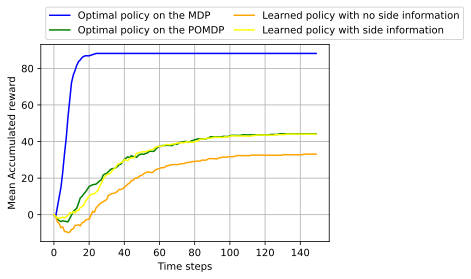

In [23]:
nData = 150
plt.figure()
plot_pol(rewDataMdpOpt, nData, color='blue', label='Optimal policy on the MDP', alpha=1, plot_std=False)
plot_pol(rewDataPomdpOpt, nData, color='green', label='Optimal policy on the POMDP', alpha=0.8, plot_std=False)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)
plot_pol(rewDataPomdpNoSi, nData, color='orange', label='Learned policy with no side information', alpha = 0.6, plot_std=False)
plot_pol(rewDataPomdpSi, nData, color='yellow', label='Learned policy with side information', alpha=0.6, plot_std=False)
# plot_pol(rewDataSideInfoLp, color='cyan', label='Learned policy with side information,0.7', alpha=0.2)
plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=2, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()